We'll start with a super easy example, the obligatory `iris` dataset with a random forest classifier. Below we set up the model using scikit-learn, everything so far should look very familiar.


In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

np.random.seed(123)

iris = load_iris()
random_forest = RandomForestClassifier()

Since we'll use GPT-4 for the tutorial, and because GPT-4 is very smart, it probably knows the `iris` dataset anyway. To trick it a little bit into thinking we have a new dataset, let's just rename the features and "jumble" the data a bit.


In [2]:
feature_names = ["length of table", "width of table", "length of dresser", "width of dresser"]
class_names = ["living room", "bedroom", "dining room"]

X = iris.data * 1.8182
y = iris.target
random_forest.fit(X, y)

RandomForestClassifier()

## Explaining the Model

From here, we've fit the model and we can run predictions against the model with new data.


In [3]:
import numpy as np

new_observation = np.random.rand(1, 4)

new_observation

array([[0.12062867, 0.8263408 , 0.60306013, 0.54506801]])

In [4]:
random_forest.predict_proba(new_observation)

array([[0.96, 0.04, 0.  ]])

Now we can say that the most likely class to which our new observation belongs is `living room`. Of course, from here, we have a lot of questions. And if we don't then the people we show our models to sure will 😅.

The random forest in scikit has some nice utilities for helping to diagnose what our model is doing under the hood. We can get the feature importances from the model.


In [5]:
random_forest.feature_importances_

array([0.08738947, 0.0257446 , 0.4611169 , 0.42574903])

We can even look at the decision path our new data took to reach it's prediction.


In [6]:
random_forest.decision_path(new_observation)

(<1x1708 sparse matrix of type '<class 'numpy.int64'>'
 	with 226 stored elements in Compressed Sparse Row format>,
 array([   0,   17,   38,   59,   82,   97,  110,  123,  138,  157,  170,
         183,  206,  225,  246,  269,  298,  323,  330,  347,  358,  375,
         388,  407,  422,  447,  474,  493,  510,  525,  542,  549,  562,
         581,  598,  611,  624,  641,  656,  675,  700,  715,  724,  747,
         764,  777,  790,  803,  818,  835,  858,  873,  890,  911,  934,
         949,  962,  977,  990, 1003, 1028, 1041, 1060, 1071, 1094, 1107,
        1120, 1135, 1156, 1167, 1186, 1201, 1216, 1239, 1258, 1271, 1278,
        1299, 1318, 1341, 1362, 1391, 1408, 1427, 1444, 1457, 1472, 1493,
        1512, 1525, 1538, 1553, 1574, 1597, 1620, 1635, 1652, 1669, 1680,
        1691, 1708]))

Great! We're done!

### Not So Fast...

So, at this point there are a couple of issues.

1.) What the heck does any of that mean? I'm a data scientist, and even I don't think any of this output is useful.
2.) This works for a random forest. Does it work for anything else? Can I use it in any scikit model? What about outside of scikit?
3.) How do I make this make sense for a variety of different audiences? How do I explain it to my boss? The woman in accounting I'm building the model for? My mom?

Let's start with #2. There have been many advances in explainable machine learning in recent years, and a big focus has been on creating model-agnostic explainers. Two of the biggest ones are SHAP](https://shap.readthedocs.io/en/latest/tabular_examples.html) and [LIME](https://github.com/marcotcr/lime).

So, if we use model-agnostic explainers what do we get?


In [7]:
import shap

shap_sample = shap.utils.sample(X, 10)

explainer = shap.Explainer(random_forest.predict, shap_sample)
shap_values = explainer(X)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Then we can even print out a nice plot!


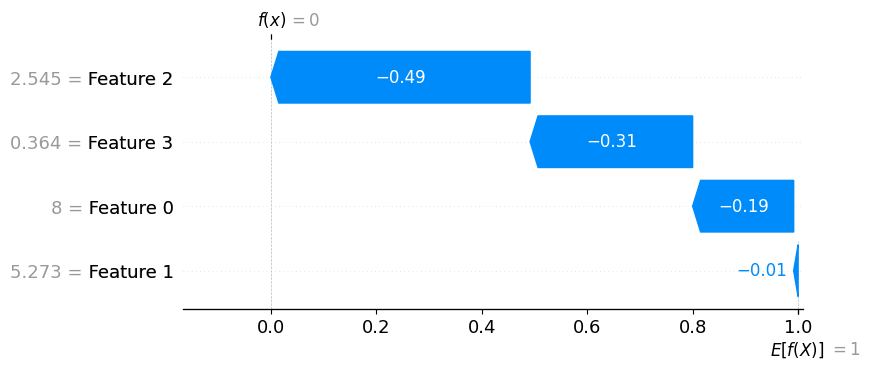

In [8]:
shap.plots.waterfall(shap_values[8], max_display=14)

This is great, but it's still missing something. You still need to explain to a layperson what they're looking at. This might help solve issue 1.) from above, but issue 3.) remains. We can make sense of the SHAP scores if they are displayed to us nicely, but we still need to know what the SHAP score is doing. Can we do better?

## Creating an Explainer that Explains

SHAP is great; we don't want to redo the wheel. What we want to do is solve issue 3.) from above. To do so, let's wrap up everything we have in a simple class, similar to the `Explainer` in the `shap` library.


In [9]:
from hierophant.explainer import Explainer

explainer = Explainer(
    random_forest,
    features=X,
    feature_names=feature_names,
    class_names=class_names,
    output=y,
    target_audience="a business person with a solid understanding of basic statistics"
    )

You might see that `target_audience` is something new. This takes in a natural-language prompt explaining 

Just like before we can print out the SHAP value.


In [10]:
explainer.add_shap(shap_sample)

In [11]:
explainer.explain()

Based on the SHAP analysis, we can provide a detailed summary of the findings for the machine learning model. However, it seems that there are no specific results or findings available for this model. It is possible that the model did not provide any SHAP values or that the SHAP analysis was not conducted for this particular model.

Without any specific results, it is difficult to provide a detailed summary of the findings. It is important to note that SHAP values are useful in understanding the contribution of each feature towards the model's predictions. They help in explaining why the model made the predictions it did by quantifying the impact of each feature.

In a typical scenario, if we had the SHAP values, we could have identified the features that had the most significant positive or negative impact on the model's predictions. This information would have been valuable for a business person with a solid understanding of basic statistics, as it would have provided insights into w

Based on the LIME instance explainer, we can see the feature contributions for each instance in the form of feature-weight pairs. Each tuple represents a feature and its impact on the prediction for a specific instance.

For example, in the first tuple, we see that the width of the dresser being less than or equal to 0.55 has a negative weight of -0.195, indicating that this feature decreases the prediction for that instance. Similarly, the length of the dresser being less than or equal to 2.91 also has a negative weight of -0.176, suggesting that it decreases the prediction as well. On the other hand, the feature "9.27 < length of table <= 10.55" has a positive weight of 0.032, indicating that it increases the prediction. The feature "width of table > 6.00" also has a positive weight of 0.012, suggesting that it increases the prediction.

These feature-weight pairs provide insights into how each feature contributes to the prediction for each instance. By examining these contributions,